# entrainement arbre de decision #

# imports #

In [2]:
import torch
import numpy as np
import os
import joblib

## import du dataset ##
on utilise encore des .pt alors que c'est pas necessaire pour rester général par rapport au mlp => on multiplie pas les datasets

In [3]:

root = "C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset/"
inputs = []
targets = []
for dirpath, dirnames, filenames in os.walk(root):
    for filename in filenames:
        if filename.endswith(".pt"):

                path = root + "/" + filename
                print(path)
                data = torch.load(path,weights_only=False)
                input_array = data["input"]
                print(np.shape(input_array))
                input = input_array.reshape(-1)
                input = input.numpy()
                target = data["output"]
                target = target.numpy()
                inputs.append(input)
                targets.append(target)
X = np.stack(inputs)
y = np.stack(targets)
print(np.shape(X))
print(y)

C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0705_00_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0705_15_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0705_30_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0705_45_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0706_00_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0706_15_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0706_30_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0706_45_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0707_15_00.pt
torch.Size([283])
C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset//25_07_0707_30_00.pt
torch.Size([283])


## séparation données train/test et entrainement de l'arbre multiclass (il y a un arbre par classe ##

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train.shape)
print(X_train.shape)
base_tree = DecisionTreeClassifier(max_depth=3)
clf = MultiOutputClassifier(base_tree)
clf.fit(X_train, y_train)


(1106, 12)
(1106, 283)


,estimator,DecisionTreeC...r(max_depth=3)
,n_jobs,None
,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None


## plot des arbres (utilisés dans le streamlit ##

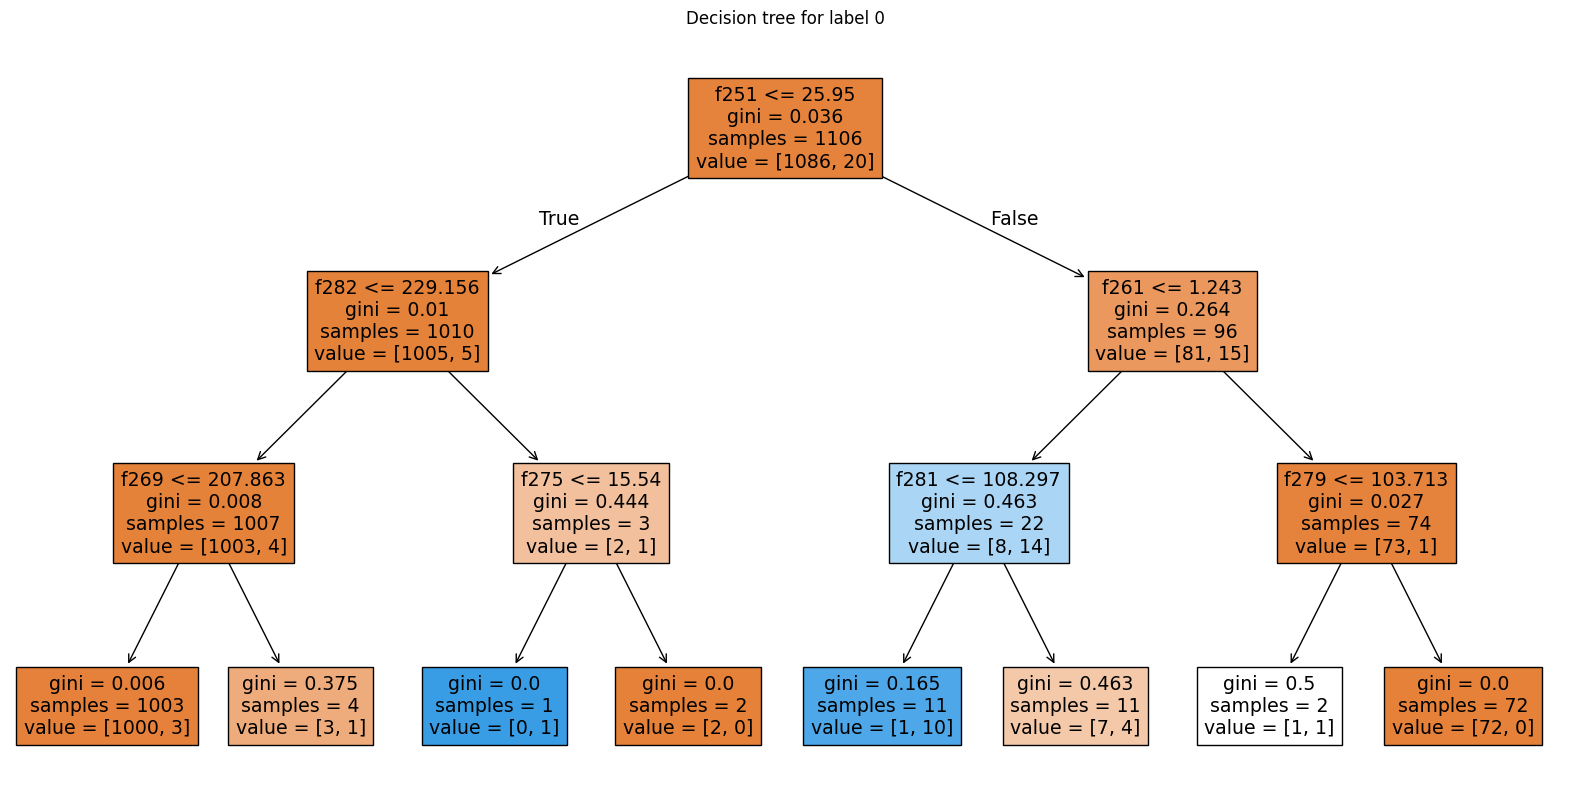

In [5]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
feature_names = np.linspace(0,242,243)
class_labels = ["Distribution__Ht_+2_Pmp2A",  "Distribution__Ht_+2_Pmp2B",  "Distribution__Ht_+27_Pmp1A",  "Distribution__Ht_+27_Pmp1B", "Distribution__Ht_-4_Pmp3A","Distribution__Ht_-4_Pmp3B","Distribution__Ht_Rad_Pmp1","Distribution__Ht_Rad_Pmp2","Production_Boiler1","Production_Boiler2","Production_Boiler3","Production_cogen"]
plot_tree(clf.estimators_[4], filled=True, feature_names=[f"f{i}" for i in range(X.shape[1])])
plt.title("Decision tree for label 0")
plt.show()

## predictions ##

In [6]:
def predict(X,clf):
    input = X
    input = input.reshape(1, -1)
    y_pred = clf.predict(input)
    return y_pred
y = y_test[0]
y_pred = predict(X_test[0],clf)
print(f"y_pred {y_pred}")
print(f"y {y}")
probas = clf.predict_proba(X_test)

y_pred [[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]
y [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]


## calcul losses ##

In [7]:
from sklearn.metrics import f1_score, hamming_loss
binary_preds = []
for x in X_test:
    input = x.reshape(1, -1)
    pred = clf.predict(input)  # Liste de 11 tableaux (1D), un par classe
    binary_preds.append(pred[0])
binary_preds = np.array(binary_preds)
print("F1 score (micro):", f1_score(y_test, binary_preds, average='micro'))
print("Hamming loss:", hamming_loss(y_test, binary_preds))

F1 score (micro): 0.9108159392789373
Hamming loss: 0.014139590854392299


In [8]:
# Sauvegarde
joblib.dump(clf, "modele_multioutput.pkl")

['modele_multioutput.pkl']

## test d'utilisations ##

In [12]:
#test
test = torch.load('C:/Users/hugom/OneDrive/Documents/Stage_2025/dev_Cnn/dataset/25_07_0706_45_00.pt',weights_only=False)
X = test['input']
X = X.reshape(-1)
X = X.numpy()
print(np.shape(X))
clf_reloaded = joblib.load("modele_multioutput.pkl")
y_pred = predict(X,clf_reloaded)
print(f"y {test['output']}")
print(f"y_pred {y_pred}")

(283,)
y tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
y_pred [[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [13]:
for i in range(len(class_labels)):
    if y_pred[0][i]==1:
        print(f"dérive de commande pour la {class_labels[i]}")

dérive de commande pour la Distribution__Ht_+27_Pmp1B
dérive de commande pour la Distribution__Ht_-4_Pmp3B
